# Mathematical Underpinnings - Lab 7

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

2024-04-16 10:51:06.163940: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 10:51:07.384398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Task 1

### a)

In [2]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
        - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    # density of multivariate normal distribution is e.g. here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

In [4]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

# np.random.seed(123)
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))


In [5]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [6]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [7]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.3628274735060617

In [8]:
# 18:56

### c)

In [9]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term)

### d)

In [12]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

2024-04-16 10:51:51.549559: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 10:51:51.655239: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [14]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: -0.0435 - val_loss: -0.0448
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0515 - val_loss: -0.0508
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0519 - val_loss: -0.0546
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0665 - val_loss: -0.0573
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0708 - val_loss: -0.0595
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0718 - val_loss: -0.0615
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0667 - val_loss: -0.0635
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0719 - val_loss: -0.0653
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0760 - val_loss: -0.0671
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0741 - val_loss: -0.0690
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0816 - val_loss: -0.0709
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

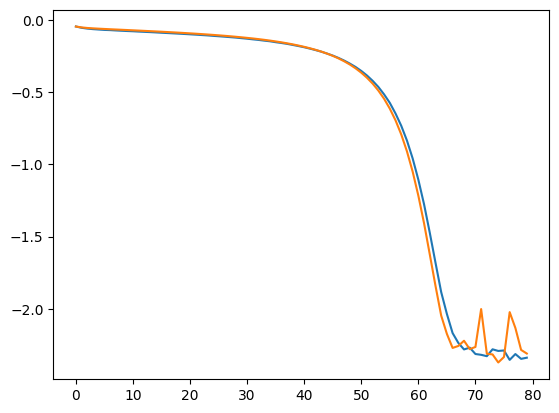

In [31]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [32]:
t_x_pred = model.predict(x)[:,0]

  1/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [33]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

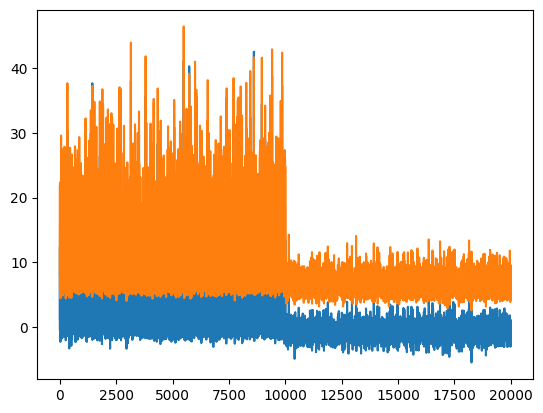

In [34]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

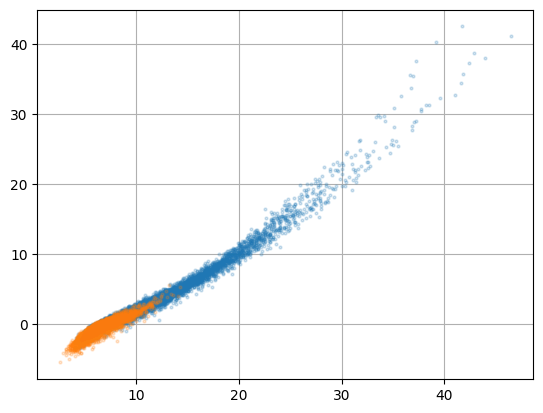

In [35]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

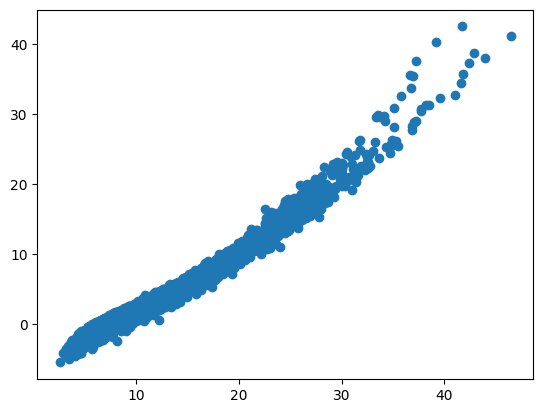

In [36]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [37]:
DV_fun(y, t_x_pred)

2.293194762520617

In [38]:
DV_fun(y, t_x_opt)

2.3628274735060617

In [39]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [40]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

  1/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [41]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [42]:
DV_fun(y_new, t_x_pred)

0.7182641648103871

In [43]:
DV_fun(y_new, t_x_opt)

1.4073648809777284

### f)

In [44]:
# def NWJ_loss(y_true, y_pred):
#     pass

In [96]:
def NWJ_loss(y_true, y_pred):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(y_pred, y_true))/n1
    second_term = tf.math.reduce_mean(tf.math.exp(y_pred[y_true == 0]-1))
    return -(first_term - second_term)

In [97]:
def NWJ_fun(y, t):
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.sum(np.exp(t[y == 0] - 1))/n2

In [98]:
# HOMEWORK - just f)

Rerunning code from point d)

In [104]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
# layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [105]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [106]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5741 - val_loss: 1.0361
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8791 - val_loss: 0.4389
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3260 - val_loss: 0.0613
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - val_loss: -0.0562
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0695 - val_loss: -0.0678
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0768 - val_loss: -0.0801
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0948 - val_loss: -0.0885
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0974 - val_loss: -0.0959
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0984 - val_loss: -0.1047
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.1092 - val_loss: -0.1142
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.1231 - val_loss: -0.1254
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

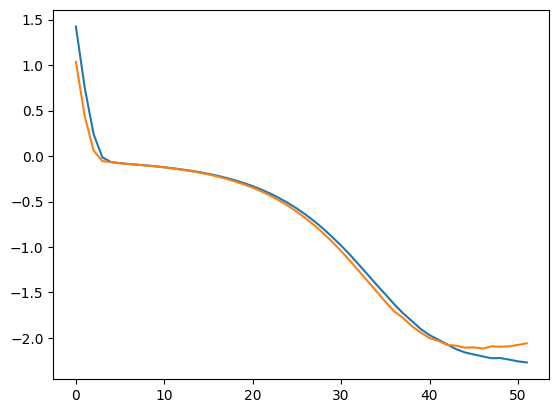

In [107]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

Repeating code from point e)

In [109]:
t_x_pred = model.predict(x)[:,0]

  1/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step


In [110]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

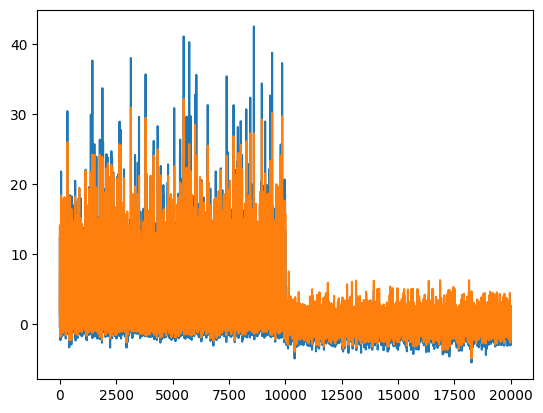

In [111]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

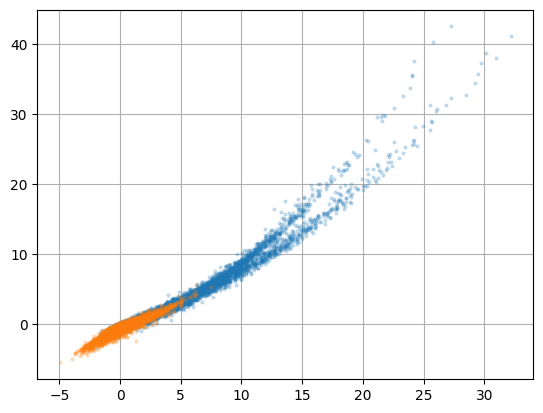

In [112]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

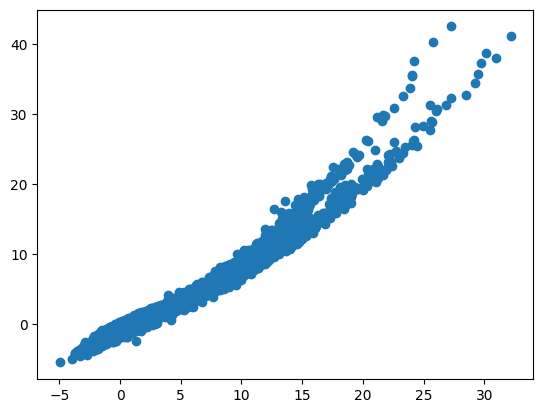

In [113]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [114]:
DV_fun(y, t_x_pred)

2.2311780731443296

In [115]:
DV_fun(y, t_x_opt)

2.3628274735060617

In [116]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [117]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

  1/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [118]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [119]:
DV_fun(y_new, t_x_pred)

1.989425530616955

In [120]:
DV_fun(y_new, t_x_opt)

2.2140904318816914